In [1]:
import optimal_transport_V2 as ot
import mass_update_V2 as mu
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D
from joblib import Parallel, delayed
import os, math, logging, traceback
from pathlib import Path
from contextlib import redirect_stdout, redirect_stderr

In [2]:
def _lam_tag(lam):
    # safe filename: 0.5 -> 0p5, -3 -> neg3
    return str(lam).replace('-', 'neg').replace('.', 'p')

def _one_lambda_joblib_collect_inner(lam, Y, con, freq, numReps, v):
    density = ot.make_product_beta_density(con, con, con, con, freq)
    N = Y.shape[0]
    import types
    lines = []
    def _plot(y, *args, **kwargs):
        lines.append(np.asarray(y).ravel().copy())
    cap = types.SimpleNamespace(
        plot=_plot,
        set_ylim=lambda *a, **k: None,
        set_title=lambda *a, **k: None
    )
    bestW, objVals, wassers, klCosts = mu.mass_update_repeated_runner(
        Y, numReps, np.ones(N), density, "absolute", .5, lam,
        numGstepsPerIter=1000, traceCanvas=cap, upperLimOnTracePlot=.045, verbose=v
    )
    return {
        "lam": float(lam),
        "bestWeights": bestW,
        "objVals": np.asarray(objVals, dtype=float),
        "wasser_per_rep": np.asarray(wassers, dtype=float),
        "klCosts": np.asarray(klCosts, dtype=float),
        "bestWasser": float(np.min(wassers)),
        "weights_per_rep": lines,
    }

def _one_lambda_joblib_collect(lam, Y, con, freq, numReps, v, log_dir="logs"):
    """
    Worker wrapper:
      - redirects stdout/stderr+logging to logs/lambda_<lam>.log live
      - on exception, writes logs/lambda_<lam>_ERROR.log with traceback
      - returns a placeholder dict with an 'error' key (so the pool continues)
    """
    log_path = Path(log_dir)
    log_path.mkdir(parents=True, exist_ok=True)
    tag = _lam_tag(lam)
    main_log = log_path / f"lambda_{tag}.log"
    err_log  = log_path / f"lambda_{tag}_ERROR.log"
    # Write live output during run
    try:
        with open(main_log, "w", buffering=1, encoding="utf-8") as f, \
             redirect_stdout(f), redirect_stderr(f):
            logging.getLogger().handlers.clear()
            logging.basicConfig(level=logging.INFO, stream=f, force=True)
            print(f"=== START λ={lam} ===", flush=True)
            res = _one_lambda_joblib_collect_inner(lam, Y, con, freq, numReps, v)
            print(f"=== END   λ={lam} ===", flush=True)
            return res
    except Exception as e:
        tb = traceback.format_exc()
        with open(err_log, "w", encoding="utf-8") as ef:
            ef.write(f">>> ERROR for λ={lam}: {e}\n\n")
            ef.write(tb)
        # also append a pointer to the error file into the main log
        try:
            with open(main_log, "a", encoding="utf-8") as f:
                f.write(f"\n[ERROR] See {err_log.name} for traceback.\n")
        except Exception:
            pass
        return {"lam": float(lam), "error": str(e), "traceback_file": str(err_log)}

def runBetaExperiment_parallel(Z, m_cont, l_cont, lams, con, freq, numReps, v, log_dir="logs"):
    Y = np.vstack([
        np.column_stack([np.random.beta(con, con, Z - 4*m_cont),
                         np.random.beta(con, con, Z - 4*m_cont)]),
        np.column_stack([np.random.beta(1, l_cont, m_cont),
                         np.random.beta(1, l_cont, m_cont)]),
        np.column_stack([np.random.beta(1, l_cont, m_cont),
                         np.random.beta(l_cont, 1, m_cont)]),
        np.column_stack([np.random.beta(l_cont, 1, m_cont),
                         np.random.beta(1, l_cont, m_cont)]),
        np.column_stack([np.random.beta(l_cont, 1, m_cont),
                         np.random.beta(l_cont, 1, m_cont)])
    ])
    n_jobs = min(len(lams), os.cpu_count() or 1)
    results = Parallel(n_jobs=n_jobs, backend="loky", verbose=0)(
        delayed(_one_lambda_joblib_collect)(lam, Y, con, freq, numReps, v, log_dir)
        for lam in lams
    )
    # separate successes & failures without crashing
    oks  = [r for r in results if "error" not in r]
    errs = [r for r in results if "error" in r]
    # sort for consistent plotting
    oks.sort(key=lambda d: d["lam"])
    # optional: quick console summary
    if errs:
        print(f"[WARN] {len(errs)} job(s) failed:", [e["lam"] for e in errs])
        print("       See per-lambda *_ERROR.log files in", log_dir)
    # ---- plotting only for successful λ ----
    if not oks:
        raise RuntimeError("All λ jobs failed. Check logs in: " + str(log_dir))
    fig, axes = plt.subplots(len(oks)+1, 2, figsize=(10, 6 + 3*len(oks)))
    axLastA = axes[len(oks), 0]
    axLastB = axes[len(oks), 1]
    bestObjs = []
    for k, d in enumerate(oks):
        lam = d["lam"]
        weights_per_rep = d["weights_per_rep"]
        bestObjs.append(d["bestWasser"])
        ax = axes[k, 0]
        for w in weights_per_rep:
            ax.plot(np.sort(w), alpha=0.3)
        ax.set_title(f"Sorted masses for all {len(weights_per_rep)} runs (λ={lam})")
        ax = axes[k, 1]
        sc = ax.scatter(Y[:, 0], Y[:, 1], c=d["bestWeights"], cmap="viridis", vmin=0, vmax=.043)
        fig.colorbar(sc, ax=ax, label="Mass")
        ax.set_title("Best masses over the optimizations")
        axLastA.plot(np.sort(d["bestWeights"]), alpha=0.3)
    axLastA.set_title("Best masses over different λ")
    axLastB.scatter([d["lam"] for d in oks], bestObjs)
    axLastB.set_xlabel("lambda")
    axLastB.set_ylabel("Value of W2^2 at best")
    plt.suptitle(f"Beta Product Density: Concentration={con}. 1 Uniform Dataset. {numReps} Mass Inits per λ.")
    plt.tight_layout()
    plt.show()
    # ---- 3D histograms (successful λ only) ----
    bins = freq + 1
    xedges = np.linspace(0, 1, bins + 1)
    yedges = np.linspace(0, 1, bins + 1)
    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    fig3d = plt.figure(figsize=(12, 3.6 * len(oks)))
    H, _, _  = np.histogram2d(Y[:,0], Y[:,1], bins=[xedges, yedges])
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
    xpos = xpos.ravel(); ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)
    DX = dx*np.ones_like(xpos); DY = dy*np.ones_like(ypos)
    for i, d in enumerate(oks):
        lam = d["lam"]
        w   = d["bestWeights"]
        Hw, _, _ = np.histogram2d(Y[:,0], Y[:,1], bins=[xedges, yedges], weights=w)
        axL = fig3d.add_subplot(len(oks), 2, 2*i+1, projection='3d')
        axL.bar3d(xpos, ypos, zpos, DX, DY, H.ravel(), shade=True)
        axL.set_xlim(0,1); axL.set_ylim(0,1)
        axL.set_xlabel('x'); axL.set_ylabel('y'); axL.set_zlabel('Count')
        axL.set_title('Original X_data')
        axR = fig3d.add_subplot(len(oks), 2, 2*i+2, projection='3d')
        axR.bar3d(xpos, ypos, zpos, DX, DY, Hw.ravel(), shade=True)
        axR.set_xlim(0,1); axR.set_ylim(0,1)
        axR.set_xlabel('x'); axR.set_ylabel('y'); axR.set_zlabel('Weighted count')
        axR.set_title(f'Resampled (λ={lam})')
    plt.tight_layout()
    plt.show()
    return {"ok": len(oks), "failed": len(errs)}

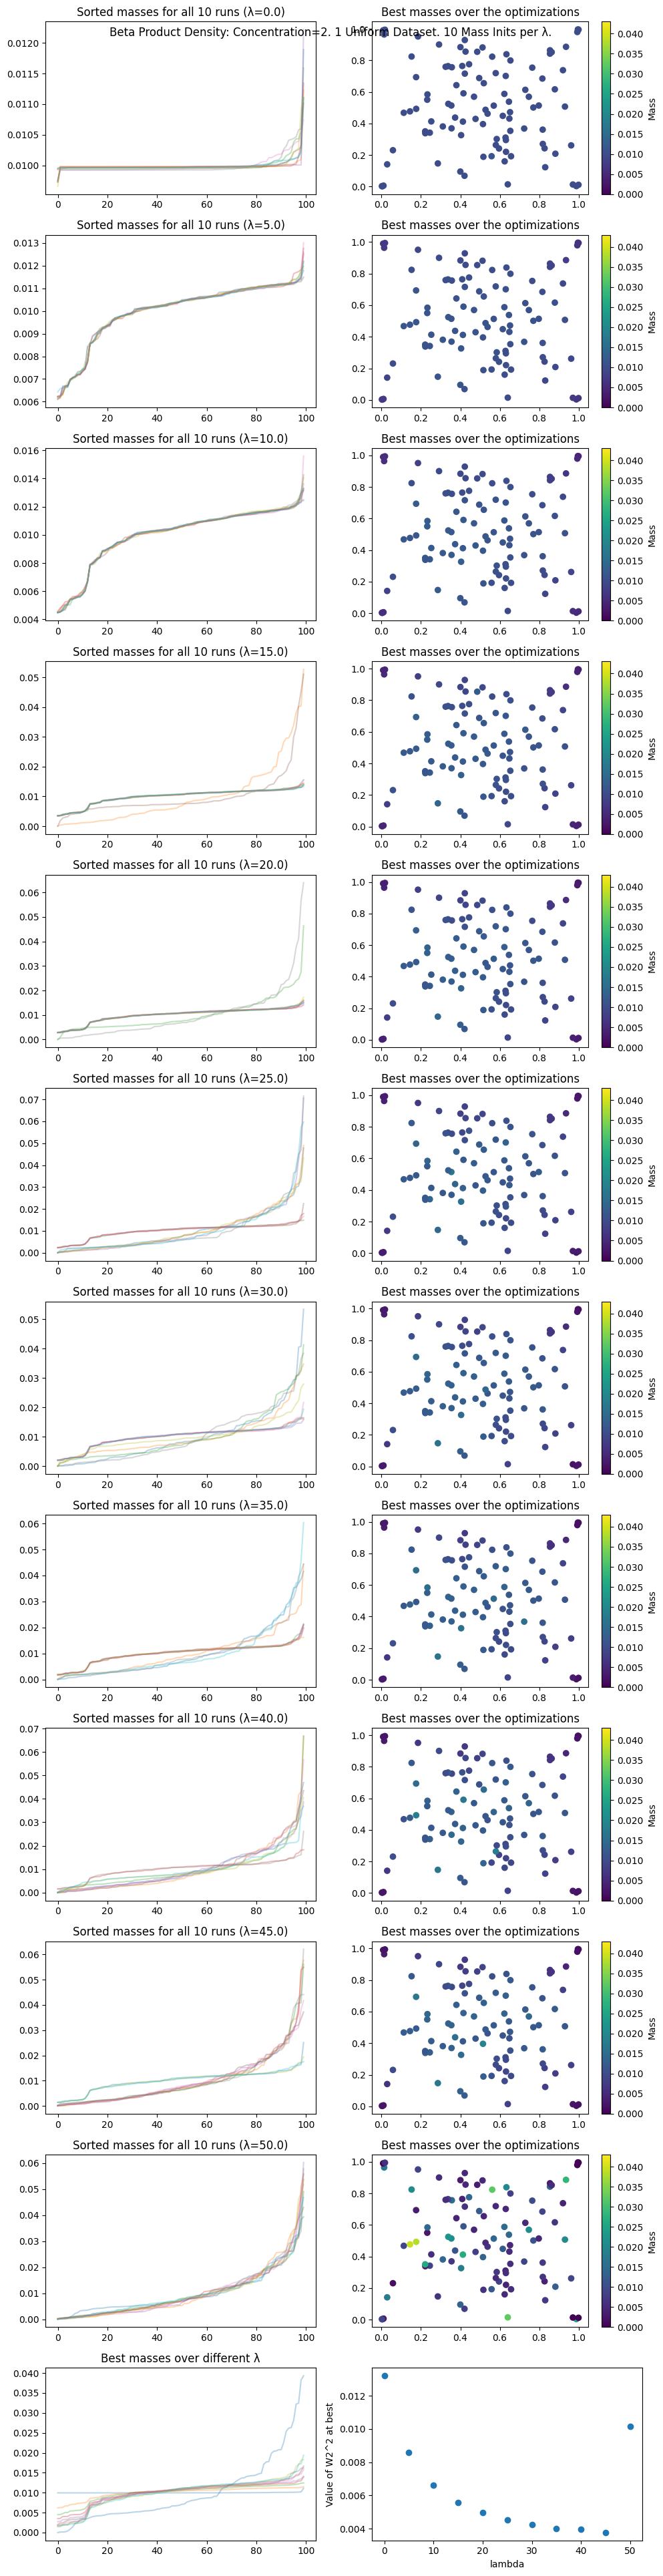

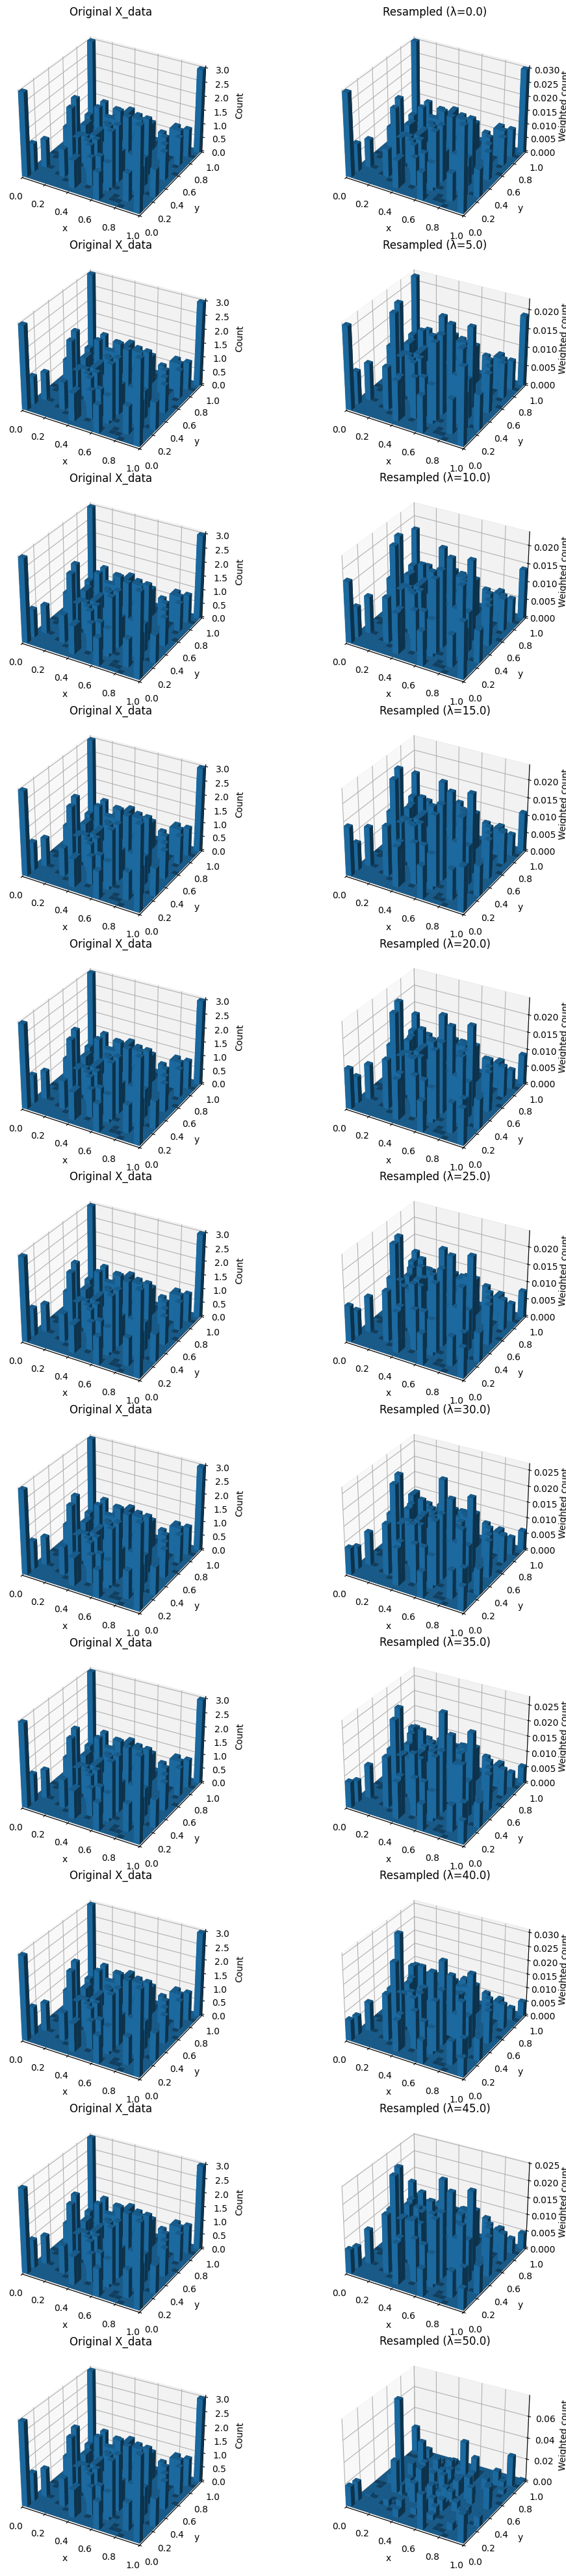

{'ok': 11, 'failed': 0}

In [3]:
np.random.seed(1)
Z = 100
m_cont = 3
l_cont = 100
lams = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
con = 2
freq = 20
numReps = 10
runBetaExperiment_parallel(Z,m_cont,l_cont,lams,con,freq,numReps,False)

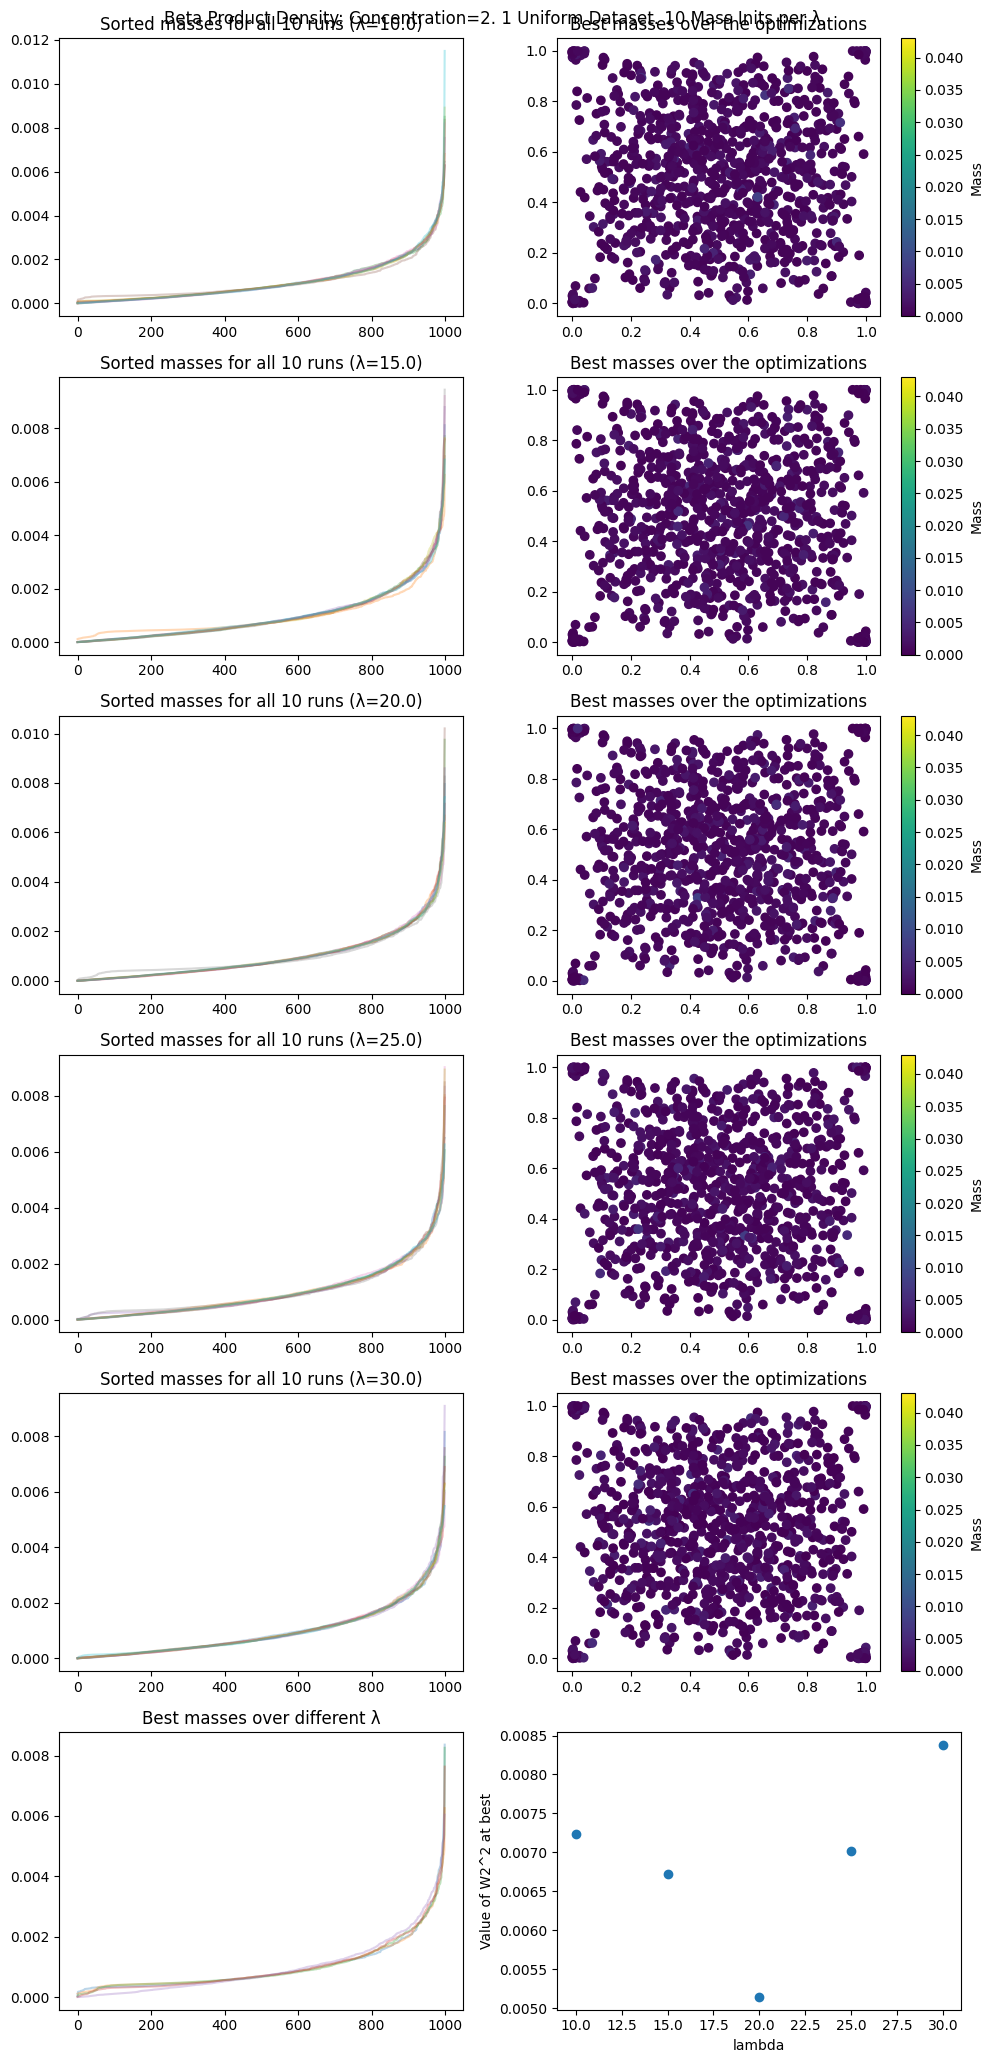

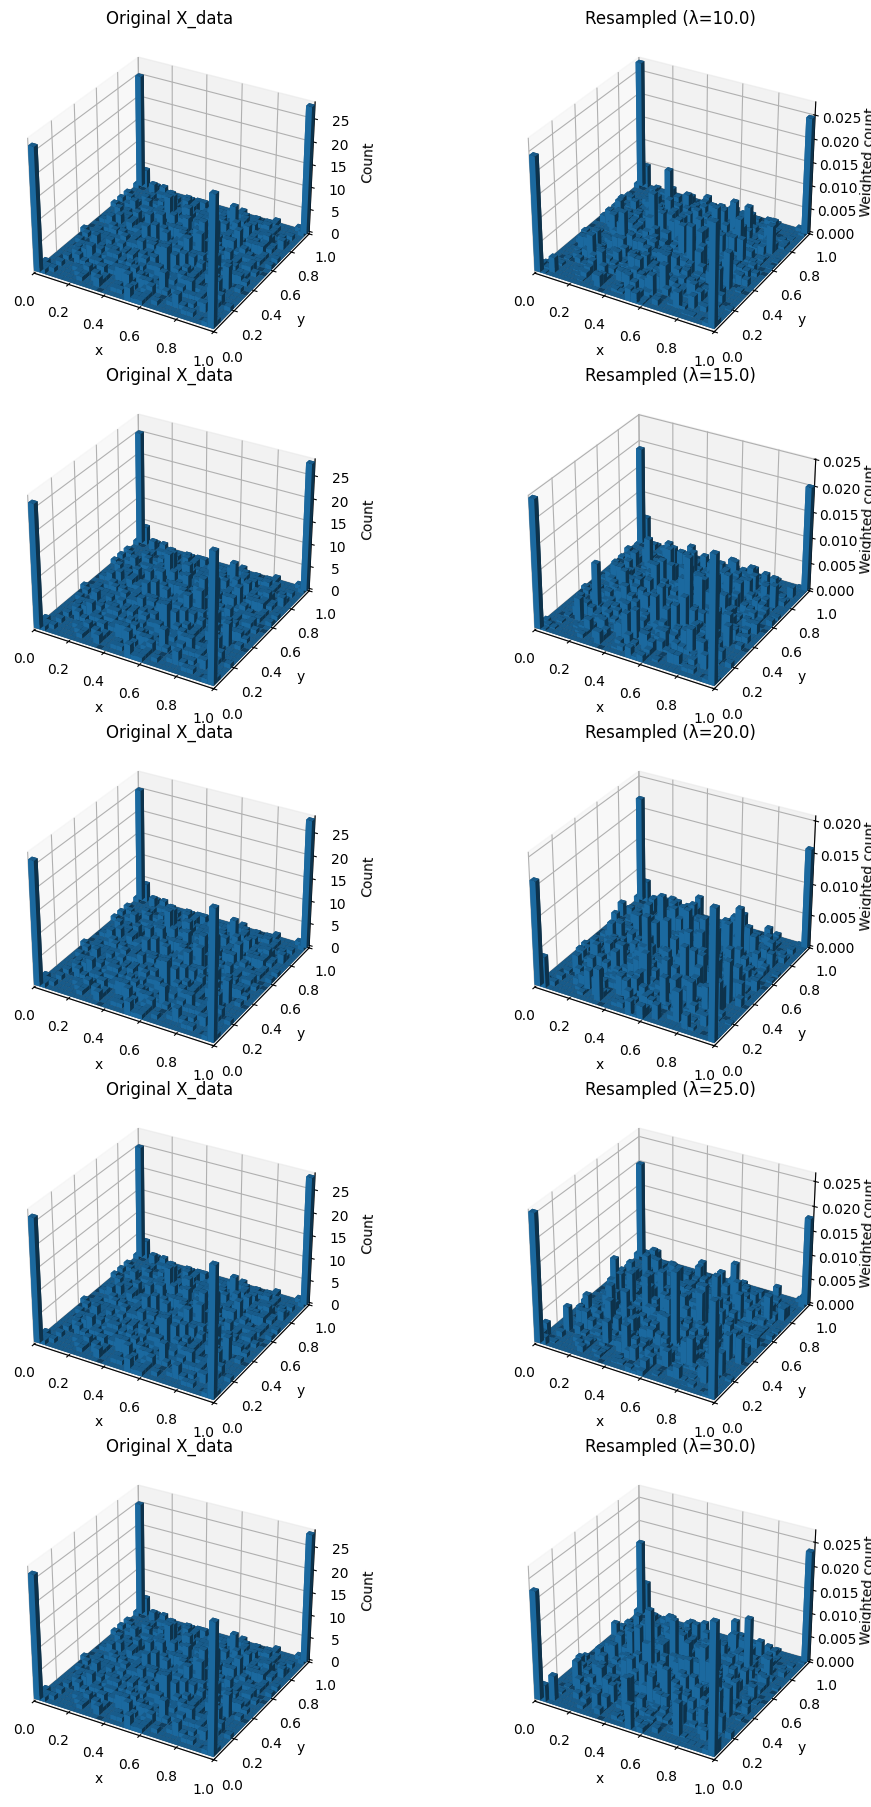

{'ok': 5, 'failed': 0}

In [5]:
np.random.seed(1)
Z = 1000
m_cont = 30
l_cont = 100
lams = [10, 15, 20, 25, 30]
con = 2
freq = 30
numReps = 10
runBetaExperiment_parallel(Z,m_cont,l_cont,lams,con,freq,numReps,True)